#Bayesian Inference to predict water well functionality.

In this notebook, we train a model using Bayesian inference and then make predictions based on this model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

Below we define the model, the prior distribution for parameters, likelihood function, and the posterior distribution.

In [2]:
def logprior(b, sigma2):
    return -np.log(sigma2)

def logistic(x, b):
    theta = linear(x,b)
    return 1.0/(1+np.exp(theta))

def linear(x, b):
    nFeat = x.shape[0]
    y = np.zeros(x.shape[1])
    for i in xrange(nFeat):
        y += x[i]*b[i+1]
    return b[0] + y
    #return b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3] + x[3]*b[4]

def loglikelihood(b, sigma2, x, y, model):
    n = len(x)
    return -n*np.log(sigma2) - 0.5*((y-model(x, b))**2).sum()/sigma2

def logpost(b, sigma2, x, y, model):
    return logprior(b, sigma2) + loglikelihood(b, sigma2, x, y, model)

We implement the MH algorithm using both blockwise updating and componentwise updating.

In [3]:
# mcmc algorithm
def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e, model):
    #MH with blockwise updating.
    nFeat = len(b_init) - 1
    
    B = np.zeros((N,nFeat + 1))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random(N)
    
    for i in xrange(N):
        b_star = np.random.normal(b_prev,be)

        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        
        p = logpost(b_star, sig2_star, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
        if np.log(r[i]) < p:
            b_prev = b_star
            sig2_prev = sig2_star
            count += 1
                           
        B[i] = b_prev
        Sig2[i] = sig2_prev
    print "The acceptance rate is "+ str(float(count)/N)+"."
    return B, Sig2

In [16]:
def mcmcComp(b_init, sig2, x, y, N, burnin, be, sig2e, model):
    #MCMC with componentwise updating instead of block updating
    nParam = len(b_init)
    
    B = np.zeros((N,nParam))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random((N,nParam+1))
    
    for i in xrange(N):
        #updating all the beta parameters
        for j in xrange(nParam):
            b_star = np.copy(b_prev)
            b_star[j] = np.random.normal(b_prev[j],be[j])
            p = logpost(b_star, sig2_prev, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
            if np.log(r[i,j]) < p:
                b_prev = b_star
                count += 1
        
        #updating sig2
        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        p = logpost(b_prev, sig2_star, x, y, model) - logpost(b_prev, sig2_prev, x, y, model)
        if np.log(r[i,-1]) < p:
            sig2_prev = sig2_star
            count += 1
        B[i] = b_prev
        Sig2[i] = sig2_prev
        
    print "The acceptance rate is "+ str(float(count)/(N*(nParam+1)))+"."
    return B, Sig2

Below are functions to import the data and process them for use in our MH sampler.

In [4]:
def import_data():
    """Import data and labels and separate into training and testing data for cross-validation."""
    #import data and labels
    train_data = pd.read_csv('Waterpump-training-values.csv')
    train_labels = pd.read_csv('Waterpump-training-labels.csv')
    
    #separating dataset into training and testing for cross-validation - 90% into training
    test_idx = np.random.uniform(0, 1, len(train_data)) <= 0.9
    train = train_data[test_idx==True]
    trainLabels = train_labels[test_idx==True]
    test = train_data[test_idx==False]
    testLabels = train_labels[test_idx==False]
    
    return train, trainLabels, test, testLabels

In [5]:
def processAllData(train, trainLabels, test, testLabels):
    """Process data for use in training and testing."""
    train, nFeatures = processData(train)
    test, _ = processData(test)
    
    trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
    trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']
    
    return train, trainLabelsVect, test, testLabels, nFeatures

def processData(data):
    """Pick out features we want to use in our model."""
    features = ['longitude', 'latitude', 'age', 'gps_height', 'dry', 'population']
    nFeatures = len(features)
    data['age'] = 2015 - data['construction_year']
    data['dry'] = data['quantity'] == 'dry'
    return np.transpose(data[features].values), nFeatures

####Blockwise Updating

First we test the blockwise updating MH algorithm.

In [6]:
train, trainLabels, test, testLabels = import_data()
train, trainLabels, test, testLabels, nFeatures = processAllData(train, trainLabels, test, testLabels)

In [7]:
numBeta = nFeatures + 1  #1 more for the constant

In [8]:
#blockwise updating
model = logistic
b_init = [-0.5, 0, 0, 0, 0, 4, 0]
be = [0.01, 0.001, 0.001, 0.001, 0.001, 0.05, 0.001]
B, sig2= mcmc(b_init, 1, train, trainLabels['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.039.


The blockwise update has an extremely low acceptance rate of 0.039, even when we start the parameters near where the componentwise updating converges. This is because we have 8 parameters!

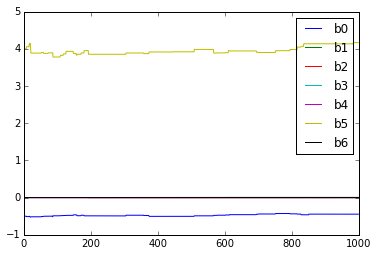

In [9]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()

Now we make predictions on the withheld data with our trained parameters.

In [11]:
b_final = B[-1,:]

In [14]:
b_final

array([ -4.45425717e-01,   5.84763518e-03,  -2.28586481e-03,
        -6.83379644e-06,  -8.01888365e-04,   4.16690859e+00,
         5.94560222e-04])

In [12]:
#predictions - these are the continuous values, need to convert to labels
yPredict = model(test, b_final)

In [13]:
n = len(testLabels)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.43201754386


Extremely low prediction accuracy of 43%.

(array([  387.,   346.,   297.,   259.,   275.,   314.,   507.,   527.,
          761.,  2321.]),
 array([ 0.00702402,  0.10604868,  0.20507335,  0.30409801,  0.40312268,
         0.50214734,  0.601172  ,  0.70019667,  0.79922133,  0.89824599,
         0.99727066]),
 <a list of 10 Patch objects>)

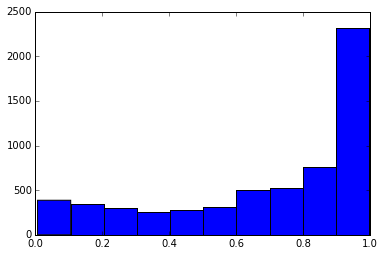

In [111]:
###plt.hist(yPredict)

######Componentwise Updating

Now we do the same process using component-wise updating.

In [20]:
#using componentwise updating
model = logistic
b_init = [0.5, 0, 0, 0, 0, 2, 0]
be = [0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
B, sig2= mcmcComp(b_init, 10, train, trainLabels['functionality'], 1000, 0, be, 0.1, model)

The acceptance rate is 0.356125.


We get a much higher acceptance rate of 35%! The trace plot below looks like it has approximately converged.

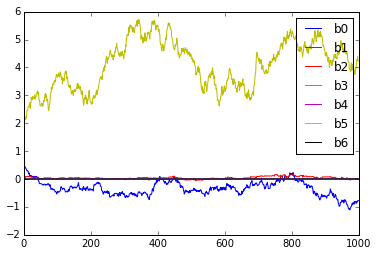

In [21]:
plt.plot(B[:,0], label='b0')
plt.plot(B[:,1], label='b1')
plt.plot(B[:,2], label='b2')
plt.plot(B[:,3], label='b3')
plt.plot(B[:,4], label='b4')
plt.plot(B[:,5], label='b5')
plt.plot(B[:,6], label='b6')
plt.legend()

In [22]:
b_final = B[-1,:]
#predictions - these are the continuous values, need to convert to labels
yPredict = model(test, b_final)
n = len(testLabels)
correct = 0.0
upBound =0.6
lowBound = 0.4
for yPred, label in zip(yPredict, testLabels['status_group']):
    if yPred >= upBound and label=='functional':
        correct += 1
    elif yPred <= lowBound and label == 'non functional':
        correct += 1
    elif yPred > lowBound and yPred < upBound and label == 'functional needs repair':
        correct += 1
print correct/n

0.606035345115


And we get 60% prediction accuracy rate with our model.